# Install and Set Up Kaggle and API Key

Follow these steps to install and configure the Kaggle API on your system:

1. **Create a Kaggle Account**
   - Visit [Kaggle](https://www.kaggle.com) and sign up for an account.

2. **Obtain Kaggle API Key**
   - Go to your Kaggle account settings.
   - Find the "API" section and click on "Create New API Token".
   - This will download a `kaggle.json` file containing your API key.

3. **Install Kaggle Package**
   - Use Conda to install the Kaggle package by running:
     ```bash
     conda install kaggle
     ```

4. **Configure API Key**
   - Copy the `kaggle.json` file to your user directory under the `.kaggle` folder. On most systems, you can use the following command:
     ```bash
     mkdir -p ~/.kaggle
     cp path_to_downloaded_kaggle.json ~/.kaggle/kaggle.json
     chmod 600 ~/.kaggle/kaggle.json
     ```
   - Ensure the `.kaggle` directory and the `kaggle.json` file have the proper permissions by setting:
     ```bash
     chmod 600 ~/.kaggle/kaggle.json
     ```


In [29]:
import pandas as pd
import kaggle
import Marketing_Campaign as mc
# Pre processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
import numpy as np


# Scoring 
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE



# models 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
#plotting
import matplotlib.pyplot as plt
import seaborn as sns


In [30]:
# Get the data using an API call
kaggle.api.dataset_download_files('rodsaldanha/arketing-campaign', path='resources', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/rodsaldanha/arketing-campaign


In [31]:
# Import the data
data = pd.read_csv("./resources/marketing_campaign.csv",delimiter=';')


# EDA (Exploratory Data Analysis)
We will revisit this. For now We want the rough draft of the model
#
During EDA

Visualize the data using plots and graphs to understand distributions and relationships between variables.
Calculate summary statistics to get a sense of the central tendencies and variability.
Identify any correlations between variables that might influence model choices.
Detect and treat missing values or outliers that could skew the results of your analysis.
Explore the data's structure to inform feature selection and engineering, which are key to building effective machine learning models.

# read any and all documentation you can find on your dataset to understand it better


In [32]:
display (data.head())
# what does our data look like? At this point also use any documentation on the data set to find out what each value means and how it might be used is solving the business problem
print (f'{data.shape}\n')


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


(2240, 29)



In [33]:
# Preprocess = Clean up NA if number of NA in column is less that a percentage of rows
# this automatically cleans up rows below a threshold and list columns when NA rows exceed the threshold
data1=mc.auto_drop_na(data,2)

Drop Percent of the rows is %2
If the number of NA values in a column is less than the calculated threshold, automatically drop the NA rows.
{'Income': 24}
Automatically dropping rows in Income where NA values are present.


In [34]:
# Identify non numeric columns we will need to deal with
non_numeric= (data1.dtypes[(data1.dtypes != 'int64') & (data1.dtypes != 'float64')]).index.tolist()
# display (data.dtypes)
print (f'Columns that are not numeric :\n {non_numeric}\n')

for column in non_numeric:
    print (data1[column].value_counts())
    print ('\n')

Columns that are not numeric :
 ['Education', 'Marital_Status', 'Dt_Customer']

Education
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: count, dtype: int64


Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64


Dt_Customer
2012-08-31    12
2012-09-12    11
2013-02-14    11
2014-05-12    11
2013-08-20    10
              ..
2012-08-05     1
2012-11-18     1
2014-05-09     1
2013-06-26     1
2014-01-09     1
Name: count, Length: 662, dtype: int64




# Numeric data to group
The year of birth data creates too many unique data to be useful. We have chosen to convert the Year Birth data to a 6 generation values. After one hot encode for generation we drop the year birth column. 

# non numeric column 
- Education OrdinalEncoder because education counts
     - 0 - **Basic** This generally refers to elementary or primary education.
     - 1 - **2n Cycle** This is not a commonly used term globally but might refer to secondary education or an intermediary level in some education systems.
     - 2 - **Graduation** Typically refers to the completion of a bachelor's or undergraduate degree.
     - 3 - **Master** A postgraduate degree that follows the completion of a bachelor's degree.
     - 4 - **PhD** The highest university degree, typically following a master's degree.

- Marital_Status - The status has no weighted values. change none standard answers to single and then one hot encode three remaining values
     - Alone     Single
     - Absurd    Single
     - YOLO      Single

- Year_Birth - Convert to 6 generations and then One Hot Encode

- Dt_Customer - We will convert to data time and represent this in number of months the cusomter has been with us

# ID column
The id column is etiher a uniwue customer id or an index falue that became a column in the past

In [35]:
# Education encode
categories = ['Basic','2n Cycle','Graduation','Master','PhD']
column = 'Education'
data2 = mc.preprocess_ord(data1,column,categories)

# One Hot ENncode
We want to One hot encode Marital status and generations.
This takes some preperation
-- Marital needs to change Alone, Absurd and YOLO to Single. 
-- Year_Birth needs to be encoded as generations first

In [36]:
# Marital Status Encode
data2['Marital_Status'] = data2['Marital_Status'].replace(['Alone', 'Absurd', 'YOLO'], 'single')

In [37]:
# transform Year_Birth to Generations
data3 = mc.set_gen(data2,'Year_Birth')

In [38]:
data4 = mc.date_to_months(data3,'Dt_Customer',2024)

In [39]:
ohe_column_list = ['Marital_Status', 'Generations']
data5 = mc.preprocess_ohe(data4,ohe_column_list)

In [40]:
# Identify columns with only one unique value
single_value_columns = data5.nunique() == 1
# Drop these columns from the DataFrame
data5 = data5.loc[:, ~single_value_columns]
data6 = data5.drop(['ID','Year_Birth'],axis=1)


# this section will address the data imbalance we see in our y value. 


In [41]:
y = data6['Response']
# Checking the distribution of classes
class_distribution = y.value_counts()
print(class_distribution)
# Getting the percentage distribution of the classes
class_percentage = y.value_counts(normalize=True) * 100
print(class_percentage)

Response
0    1883
1     333
Name: count, dtype: int64
Response
0    84.972924
1    15.027076
Name: proportion, dtype: float64


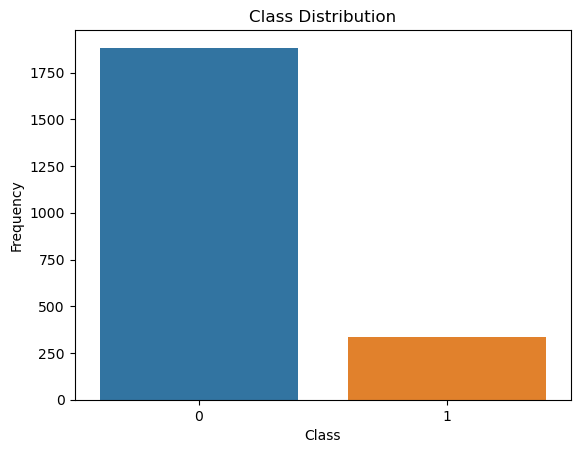

In [42]:
# Plotting the distribution of classes
sns.countplot(x=data6['Response'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

In [43]:
X=data6.drop(['Response'],axis=1)
y=data6['Response']

# life is balance

Using 

classification report for
- dataset with no changes
- dataset with underfit RandomUnderSampler
- dataset with overfit RandomOverSampler
- dataset with smote SMOTE
- dataset with smoteenn SMOTEENN

Standard Scaler

RandomForestClassifier

no results are accepable


In [48]:
# This checks the initial unblanaced score

# Step 1: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Train and evaluate a model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       382
           1       0.59      0.31      0.40        62

    accuracy                           0.87       444
   macro avg       0.74      0.64      0.67       444
weighted avg       0.85      0.87      0.86       444



In [49]:
# dataset with underfit RandomUnderSampler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Step 2: Address imbalance (only on training data)
rus= RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Step 3: Scale the data (after resampling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Train and evaluate a model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled, y_train_resampled)
y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.80      0.87       382
           1       0.39      0.81      0.53        62

    accuracy                           0.80       444
   macro avg       0.68      0.80      0.70       444
weighted avg       0.88      0.80      0.82       444



In [52]:
# dataset with underfit RandomUnderSampler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Step 2: Address imbalance (only on training data)
ros= RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Step 3: Scale the data (after resampling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Train and evaluate a model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled, y_train_resampled)
y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       382
           1       0.60      0.34      0.43        62

    accuracy                           0.88       444
   macro avg       0.75      0.65      0.68       444
weighted avg       0.86      0.88      0.86       444



In [53]:
# Step 1: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Step 2: Address imbalance (only on training data)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 3: Scale the data (after resampling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Train and evaluate a model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled, y_train_resampled)
y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.94      0.93       382
           1       0.55      0.45      0.50        62

    accuracy                           0.87       444
   macro avg       0.73      0.70      0.71       444
weighted avg       0.86      0.87      0.87       444



In [54]:

# Step 1: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Step 2: Address imbalance (only on training data)
smote = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 3: Scale the data (after resampling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Train and evaluate a model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled, y_train_resampled)
y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.85      0.89       382
           1       0.39      0.58      0.47        62

    accuracy                           0.82       444
   macro avg       0.66      0.72      0.68       444
weighted avg       0.85      0.82      0.83       444



# life is balance

Using 

classification report for
- dataset with no changes
- dataset with underfit RandomUnderSampler
- dataset with overfit RandomOverSampler
- dataset with smote SMOTE
- dataset with smoteenn SMOTEENN

Standard Scaler

RandomForestClassifier

no results are accepable


In [ ]:
# This checks the initial unblanaced score

# Step 1: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Train and evaluate a model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))